## Informações sobre o modelo desenvolvido

*   utilização de 2 meta classes a partir de 7 classes
*   imagens com dimensão reduzida e escala de preto e branco
*   BinaryDownsampling
*   EfficientNetB5

# Setup

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/Trabalho\ Sistemas\ de\ Inteligencia/ root

Mounted at /content/gdrive


In [ ]:
# manipulação de dataset
import pandas as pd

# pacote de álgebra linear, faz manipulações de vetores e etc
import numpy as np

# import pytorch as pyt
from PIL import Image, ImageOps

# functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc
import os

# used to return all file paths that match a specific pattern
import glob

# opencv-python, solve computer vision problems
import cv2

# functions to compare files and directories, with various optional time/correctness trade-offs
import filecmp

# split dataset between training and testing data
from sklearn.model_selection import train_test_split

# preprocessing and Normalization, includes scaling, centering, normalization, binarization methods.
from sklearn import preprocessing

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential

from google.colab.patches import cv2_imshow

# Leitura do dataset não processado

In [ ]:
groundTruthPath = 'root/GroundTruth.csv'

In [ ]:
originalDataset = pd.read_csv(groundTruthPath)
originalDataset.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Transforma onehot encoder em labels qualitativos**

Onehot encoder é uma técnica que transforma valores qualitativos em quantitativos através da geração de conjuntos R^(numero de classes)

In [ ]:

labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]

detailedDataset = originalDataset.copy()

for i in range (len(originalDataset)):
    row = list(originalDataset.iloc[i])
    del row[0]
    index = np.argmax(row)
    label = labels[index]
    label_list.append(label)
    
detailedDataset['label'] = label_list
detailedDataset = detailedDataset.drop(labels, axis=1)
detailedDataset.head()

,image,label
0,ISIC_0024306,NV
1,ISIC_0024307,NV
2,ISIC_0024308,NV
3,ISIC_0024309,NV
4,ISIC_0024310,MEL


# Amostragem dos dados do dataset com as 7 classes de lesões

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64


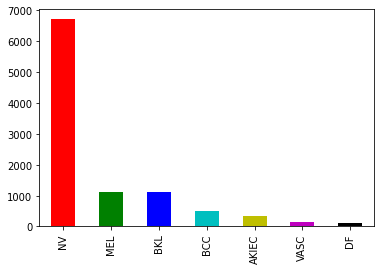

In [ ]:
detailedDataset['label'].value_counts().plot.bar(color=['r','g','b','c','y','m','k'])
print(detailedDataset['label'].value_counts())

# Divisão do dataset em meta-classes: benignos e malignos

Estratégia inicial para verificar o resultado do modelo com balancea,emto por subamostragem (downsampling) entre as duas meta-classes


In [ ]:
benignLesions = ['NV', 'BKL', 'DF', 'VASC']
malignLesions = ['MEL', 'BCC', 'AKIEC']
benignCode = 'Benigno'
malignCode = 'Maligno'

simplifiedDataset = detailedDataset.copy()

def classifyLesions(row):
  if row['label'] in benignLesions:
    return benignCode
  return malignCode

simplifiedDataset['type'] = simplifiedDataset.apply (lambda row: classifyLesions(row), axis=1)
simplifiedDataset = simplifiedDataset.drop('label', axis=1)
simplifiedDataset.head()

,image,type
0,ISIC_0024306,Benigno
1,ISIC_0024307,Benigno
2,ISIC_0024308,Benigno
3,ISIC_0024309,Benigno
4,ISIC_0024310,Maligno


# Balanceamento

A importância do balanceamento está na etapa de treinamento, entretando ele é realizado com a base inteira antes do treino e teste para não enviesar conjuntos de dados.

Importante deixar cada classe com a quantidade de imagens mais parecida possível.

Nessa abordagem inicial mais simples, queremos somente dividir o data set em duas classes e deixar a mesma quantidade de imagens para cada classe.

In [ ]:
print('original number of classes: ', len(detailedDataset['label'].unique()))     

original number of classes:  7


Benigno    8061
Maligno    1954
Name: type, dtype: int64



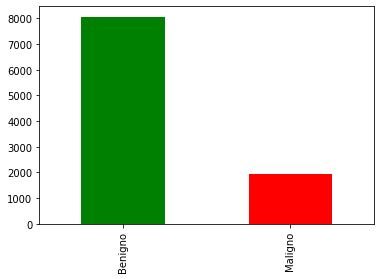

In [ ]:
simplifiedDataset['type'].value_counts().plot.bar(color=['g','r'])
print(simplifiedDataset['type'].value_counts())
print()

In [ ]:
df = simplifiedDataset;
print(df)

              image     type
0      ISIC_0024306  Benigno
1      ISIC_0024307  Benigno
2      ISIC_0024308  Benigno
3      ISIC_0024309  Benigno
4      ISIC_0024310  Maligno
...             ...      ...
10010  ISIC_0034316  Maligno
10011  ISIC_0034317  Maligno
10012  ISIC_0034318  Benigno
10013  ISIC_0034319  Benigno
10014  ISIC_0034320  Benigno

[10015 rows x 2 columns]


dataset is highly out of balance limit maximum samples per class to 1954 (balanceamento por baixo) samples to help balance it

In [ ]:
#size = 1954 # set number of samples for each class
size= 1954 # set number of samples for each class
samples = []

group=df.groupby('type')

for label in df['type'].unique():
    Lgroup=group.get_group(label)
    count=int(Lgroup['type'].value_counts())    
    if count>=size:
        sample=Lgroup.sample(size, axis=0)        
    else:        
        sample=Lgroup.sample(frac=1, axis=0)
    samples.append(sample) 

balanced_df = pd.concat(samples, axis=0).reset_index(drop=True)

print(len(balanced_df))
print('final number of classes: ', len(balanced_df['type'].unique()))       
print(balanced_df['type'].value_counts())  

3908
final number of classes:  2
Benigno    1954
Maligno    1954
Name: type, dtype: int64


# Aplicação de LabelEncoder(type)

Etapa executada antes da divisão de conjuntos para evitar custo computacional ao ter que verificar se os dois conjuntos estão se refereindo a meta classe da mesma forma.

Transformação de:
> Benigno->0

> Maligno-> 1

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [ ]:
balanced_df.head()

,image,type
0,ISIC_0031783,Benigno
1,ISIC_0025829,Benigno
2,ISIC_0033351,Benigno
3,ISIC_0030429,Benigno
4,ISIC_0025075,Benigno


In [ ]:
le = preprocessing.LabelEncoder()
balanced_df['type']=le.fit_transform(balanced_df['type'])
balanced_df.head()

,image,type
0,ISIC_0031783,0
1,ISIC_0025829,0
2,ISIC_0033351,0
3,ISIC_0030429,0
4,ISIC_0025075,0


# Train Test Split

Essa divisão do dataset está sendo feita após a etapa de balanceamento para prevenir bias (viéses) no treinamento que venham a resultar em um modelo com tendêncidas não generalizadas.
O objetivo do modelo é ser o mais geral possível

Teste será feito com 20% do dataset já balanceado
Treinamento será feito com 80% do dataset já balanceado

In [ ]:
test_size = .20 # set this to the percent of the data you want to use for validation
train_size = .80 # set this to the percentof the data you want to use for training

split_df = balanced_df.copy()
train_df, test_df = train_test_split(split_df, test_size = test_size, train_size = train_size, random_state=42, shuffle=True)

In [ ]:
print(len(test_df))
test_df.head()

782


,image,type
1896,ISIC_0026603,0
2802,ISIC_0029082,1
1962,ISIC_0032531,1
2104,ISIC_0025953,1
1539,ISIC_0030860,0


In [ ]:
print(len(train_df))
train_df.head()

3126


,image,type
247,ISIC_0030057,0
2957,ISIC_0031565,1
2622,ISIC_0030129,1
2335,ISIC_0026697,1
2775,ISIC_0033392,1


In [ ]:
for data in train_df['image']:
  print(data+'.jpg')

ISIC_0030057.jpg
ISIC_0031565.jpg
ISIC_0030129.jpg
ISIC_0026697.jpg
ISIC_0033392.jpg
ISIC_0025308.jpg
ISIC_0030025.jpg
ISIC_0026358.jpg
ISIC_0025922.jpg
ISIC_0032955.jpg
ISIC_0032414.jpg
ISIC_0029817.jpg
ISIC_0024442.jpg
ISIC_0033801.jpg
ISIC_0028828.jpg
ISIC_0033767.jpg
ISIC_0025546.jpg
ISIC_0024652.jpg
ISIC_0031838.jpg
ISIC_0031747.jpg
ISIC_0025195.jpg
ISIC_0032303.jpg
ISIC_0032146.jpg
ISIC_0025847.jpg
ISIC_0027214.jpg
ISIC_0032425.jpg
ISIC_0027564.jpg
ISIC_0027753.jpg
ISIC_0031134.jpg
ISIC_0024818.jpg
ISIC_0034081.jpg
ISIC_0032958.jpg
ISIC_0028803.jpg
ISIC_0026032.jpg
ISIC_0027663.jpg
ISIC_0027808.jpg
ISIC_0031109.jpg
ISIC_0031670.jpg
ISIC_0032179.jpg
ISIC_0029839.jpg
ISIC_0028082.jpg
ISIC_0029323.jpg
ISIC_0030075.jpg
ISIC_0026152.jpg
ISIC_0024466.jpg
ISIC_0027254.jpg
ISIC_0028132.jpg
ISIC_0029918.jpg
ISIC_0028637.jpg
ISIC_0032070.jpg
ISIC_0033987.jpg
ISIC_0033333.jpg
ISIC_0030934.jpg
ISIC_0030750.jpg
ISIC_0025192.jpg
ISIC_0027245.jpg
ISIC_0030125.jpg
ISIC_0031331.jpg
ISIC_0031520.j

# Obter as imagens do dataset

In [ ]:
PATH_PROCESSED_CONST = 'root/images/reshape-150_200/'

all_files = glob.glob(os.path.join(PATH_PROCESSED_CONST, "*.jpg"))
print(all_files[1])

root/images/reshape-150_200/ISIC_0031741.jpg


Aplicar greyscale e reshape nas imagens

In [ ]:
print(train_df['image'])

print(type(train_df['image']))

247     ISIC_0030057
2957    ISIC_0031565
2622    ISIC_0030129
2335    ISIC_0026697
2775    ISIC_0033392
            ...     
1130    ISIC_0028587
1294    ISIC_0028375
860     ISIC_0029148
3507    ISIC_0025611
3174    ISIC_0033886
Name: image, Length: 3126, dtype: object
<class 'pandas.core.series.Series'>


In [ ]:
X_train = []
X_test = []
for img_name in train_df['image']:
  img = cv2.imread(PATH_PROCESSED_CONST + str(img_name)+'.jpg')
  X_train.append(img)

for img_name in test_df['image']:
  img = cv2.imread(PATH_PROCESSED_CONST + str(img_name)+'.jpg')
  X_test.append(img)

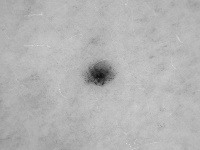

In [ ]:
cv2_imshow(X_test[0])

In [ ]:
X_train[0].shape

AttributeError: ignored

In [ ]:
print(X_train)


# Criar modelo

Construir uma rede neural CNN levando em conta a dimensão das imagens (450, 600, 3)

https://www.tensorflow.org/tutorials/images/cnn

In [ ]:
height = 450  # image height
width = 600   # image width
channels = -1  # number of color channels, RGB
batch_size = 100  # model batch size for training and evaluation
img_shape = (height, width, channels)
img_size = (height, width)
class_count = 2

Arquitetura EfficientNetB1

https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB1

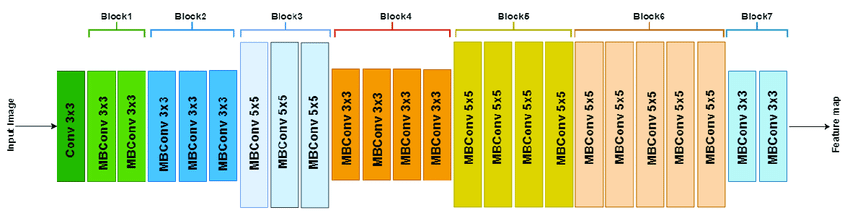

Base de dados imagenet

Utiliza os pesos da EfficientNetB1 treinada na imagenet

tf.keras.applications.efficientnet.EfficientNetB1 returns a Keras image classification model, optionally loaded with weights pre-trained on ImageNet

In [ ]:
resized_height = 150 # image height
resized_width = 200   # image width
resized_channels = 3  # number of color channels, RGB

In [ ]:
model_name = 'EfficientNetB5'
base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=(resized_height, resized_width, resized_channels), pooling='max') 
x = base_model.output

# aplicação de 4 camadas na rede neural

x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)

x = Dropout(rate=.45, seed=123)(x)

output = Dense(class_count, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

# Treinar modelo

In [ ]:
X_train = np.array(X_train)
y_train = train_df['type'].to_numpy().reshape(-1)


X_test = np.array(X_test)
y_test = test_df['type'].to_numpy().reshape(-1)

In [ ]:
X_train[0][0]

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size = batch_size,
                    validation_data=(X_test, y_test))

# Testar modelo

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)